In [1]:
%matplotlib inline

import h5py
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# reading h5 file
f_knee = 'dataset_knee/file1000612.h5'
knee = h5py.File(f_knee)

f_brain = 'dataset_brain/file_brain_AXFLAIR_200_6002467.h5'
brain = h5py.File(f_brain)

In [3]:
print("Keys: ", list(knee.keys()))
print("Attr: ", dict(knee.attrs))

print(knee['kspace'])


print("\n----BRAIN----\nKeys: ", list(brain.keys()))
print("Attr: ", dict(brain.attrs))

print(brain['kspace'])

Keys:  ['ismrmrd_header', 'kspace', 'reconstruction_rss']
Attr:  {'acquisition': 'CORPDFS_FBK', 'max': 0.0003239908310284407, 'norm': 0.09130722957017874, 'patient_id': '7a030f688bf16ce82f73c9cfc7c16091da6eb0b3745f2ed01c16cdc2ab1fe665'}
<HDF5 dataset "kspace": shape (45, 15, 640, 372), type "<c8">

----BRAIN----
Keys:  ['ismrmrd_header', 'kspace', 'reconstruction_rss']
Attr:  {'acquisition': 'AXFLAIR', 'max': 0.00032911274006692246, 'norm': 0.09918976241899105, 'patient_id': 'cd43cbcf480c4bf81d7fc0fd3691ce3e2527bd73779e0b104c4c7b5613fb9a0e'}
<HDF5 dataset "kspace": shape (16, 20, 640, 320), type "<c8">


In multi-coil MRIs, k-space has the following shape: (number of slices, number of coils, height, width)

For single-coil MRIs, k-space has the following shape: (number of slices, height, width)

MRIs are acquired as 3D volumes, the first dimension is the number of 2D slices.

In [4]:
kspace = knee['kspace'][()]
print(kspace.dtype)
print(kspace.shape)

bkspace = brain['kspace'][()]
print(bkspace.dtype)
print(bkspace.shape)

complex64
(45, 15, 640, 372)
complex64
(16, 20, 640, 320)


In [8]:
# 20th slice of the data
kspace20 = kspace[20]
print("Shape = ", kspace20.shape)

bkspace8 = bkspace[8]
print("Shape = ", bkspace8.shape)


Shape =  (15, 640, 372)
Shape =  (20, 640, 320)


Showing Data

In [11]:
def show_coils(data, slice_nums, cmap=None):
    fig = plt.figure() # from https://github.com/facebookresearch/fastMRI/blob/main/fastMRI_tutorial.ipynb
    for i, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), i + 1)
        plt.imshow(data[num], cmap='viridis', aspect='auto')


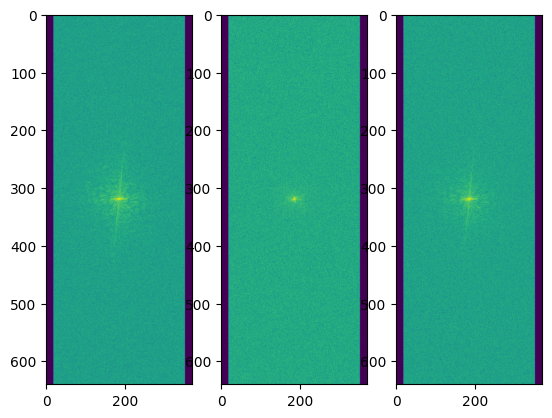

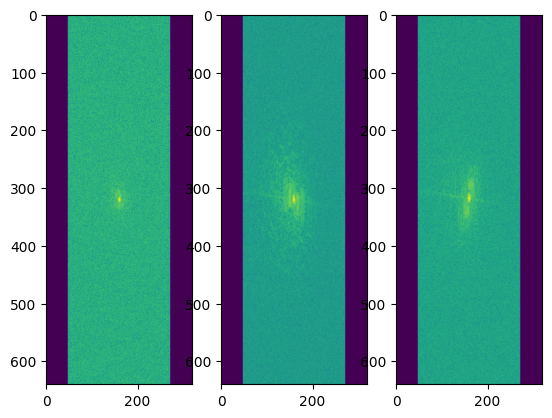

In [33]:
show_coils(np.log(np.abs(kspace20) + 1e-9), [7, 8, 9]) # coil number 0, 5, 10

show_coils(np.log(np.abs(bkspace8) + 1e-9), [0, 5, 10]) # coil number 0, 5, 10

Fourier Transformation of kspace to complex images.

In [15]:
import fastmri
from fastmri.data import transforms as T

In [16]:
kspace20t = T.to_tensor(kspace20)
transformed_data20 = fastmri.ifft2c(kspace20t)
transformed_data20_abs = fastmri.complex_abs(transformed_data20)
print("Knee Data shapes: \nKspace: {} \nTransformed {} ".format(kspace20t.shape, transformed_data20.shape))


bkspace8t = T.to_tensor(bkspace8)
btransformed_data8 = fastmri.ifft2c(bkspace8t)
btransformed_data8_abs = fastmri.complex_abs(btransformed_data8)
print("Brain Data shapes: \nKspace: {} \nTransformed {} ".format(bkspace8t.shape, btransformed_data8.shape))

Knee Data shapes: 
Kspace: torch.Size([15, 640, 372, 2]) 
Transformed torch.Size([15, 640, 372, 2]) 
Brain Data shapes: 
Kspace: torch.Size([20, 640, 320, 2]) 
Transformed torch.Size([20, 640, 320, 2]) 


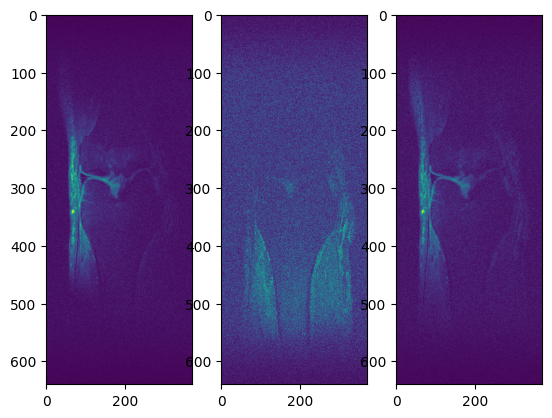

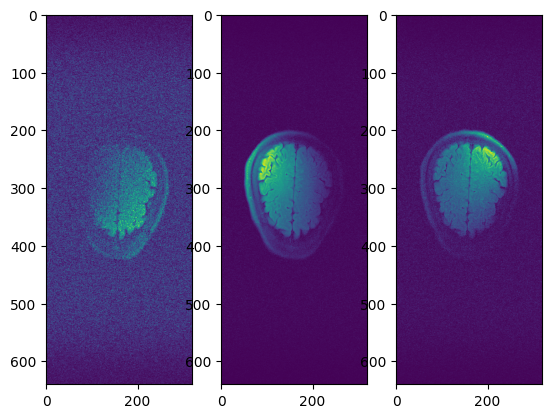

In [32]:
show_coils(transformed_data20_abs, [7, 8, 9], cmap='gray')

show_coils(btransformed_data8_abs, [0, 5, 10], cmap='gray')

As we can see, each coil in a multi-coil MRI scan focusses on a different region of the image. These coils can be combined into the full image using the Root-Sum-of-Squares (RSS) transform.

ABS: torch.Size([15, 640, 372])
RSS: torch.Size([640, 372])


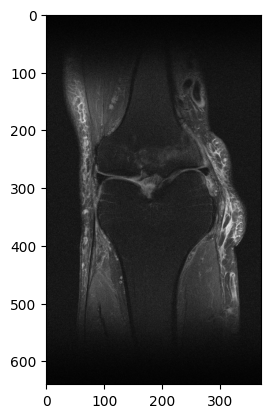

In [34]:
transformed_data20_rss = fastmri.rss(transformed_data20_abs, dim=0)
print("ABS: {}\nRSS: {}".format(transformed_data20_abs.shape, transformed_data20_rss.shape))
plt.imshow(np.abs(transformed_data20_rss.numpy()), cmap='gray')

(45, 320, 320)


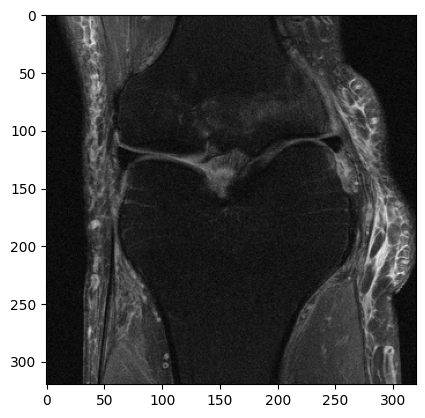

In [102]:
print(knee["reconstruction_rss"][()].shape)
plt.imshow(np.abs(knee["reconstruction_rss"][()][20]), cmap='gray')

ABS: torch.Size([20, 640, 320])
RSS: torch.Size([640, 320])


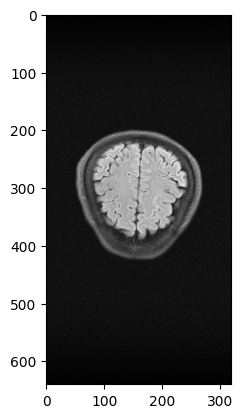

In [95]:
btransformed_data8_rss = fastmri.rss(btransformed_data8_abs, dim=0)
print("ABS: {}\nRSS: {}".format(btransformed_data8_abs.shape, btransformed_data8_rss.shape))
plt.imshow(np.abs(btransformed_data8_rss.numpy()), cmap='gray')

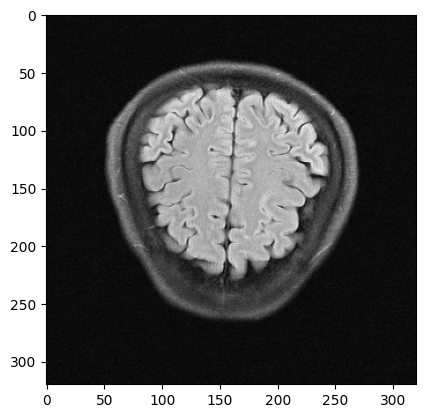

In [68]:
# print(brain["reconstruction_rss"][()][8])
plt.imshow(np.abs(brain["reconstruction_rss"][()][8]), cmap='gray')

IMG:  torch.Size([96, 640, 320])


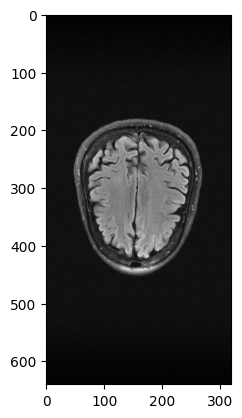

IMG:  torch.Size([96, 640, 320])


In [104]:
import torch
# stacking all files using os
import os
folder = 'brain_multicoil_train/'

file_list= [f for f in os.listdir(folder) if f.endswith('.h5')]

# file_list = file_list[:1]
img = None
rss_img = None
img_tensor = False

for f in file_list:
    brain = h5py.File(folder+f)
    ap = fastmri.ifft2c(T.to_tensor(brain['kspace'][()]))
    # print('Kspace - ', brain['kspace'][()].shape)
    ksp = fastmri.complex_abs(ap)
    # print('After Complex ABS', ap.shape)
    ksp = fastmri.rss(ksp, dim=1)
    # print('Reconstruction', ksp.shape)
    if not img_tensor:
        img = ksp
        rss_img = T.to_tensor(brain["reconstruction_rss"][()])
        img_tensor = True
    else:
        temp = torch.cat((img, ksp), dim=0)
        img = temp
        rss_img = torch.cat((rss_img, T.to_tensor(brain["reconstruction_rss"][()])))

    # print(ksp.shape," --- ",brain["reconstruction_rss"][()].shape)





print("IMG: ", img.shape)

# plt.imshow(np.abs(img[53].numpy()), cmap='gray')

RSS:  torch.Size([96, 320, 320])


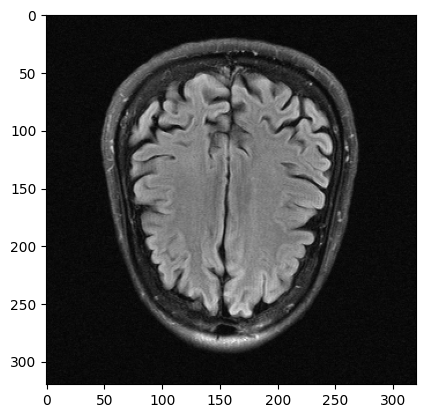

In [101]:
print("RSS: ", rss_img.shape)
plt.imshow(np.abs(rss_img[53].numpy()), cmap='gray')

In [71]:
from pathlib import Path

path = Path('brain_multicoil_train')
files = sorted(path.glob('*.h5'))

print(files[0].resolve())

with h5py.File(files[0]) as h5f:
    for k, v in h5f.items():
        # for n, p in v.items():
        print(k)
        if k!='ismrmrd_header':
            print(T.to_tensor(v[()]).shape)


/Users/mehul/TUM/WS23/Masters Praktikum - ADLM/learning-neural-implicit-representations-of-mri-data/brain_multicoil_train/file_brain_AXFLAIR_200_6002452.h5
ismrmrd_header
kspace
torch.Size([16, 20, 640, 320, 2])
reconstruction_rss
torch.Size([16, 320, 320])
